In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from multiview.cotraining.ctclassifier import CTClassifier
from multiview.datasets.base import load_UCImultifeature

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


### Function to create 2 class data

This function is used to generate examples for 2 classes from multivariate normal distributions. Once the examples are generated, it splits them into training and testing sets and returns the needed information

In [56]:
def create_data(seed, class2_mean_center, view1_var, view2_var, N_per_class):
    
    np.random.seed(seed)
    
    view1_mu0 = np.zeros(2,)
    view1_mu1 = class2_mean_center * np.ones(2,)
    view1_cov = view1_var*np.eye(2)

    view2_mu0 = np.zeros(2,)
    view2_mu1 = class2_mean_center * np.ones(2,)
    view2_cov = view2_var*np.eye(2)

    view1_class0 = np.random.multivariate_normal(view1_mu0, view1_cov, size=N_per_class)
    view1_class1 = np.random.multivariate_normal(view1_mu1, view1_cov, size=N_per_class)

    view2_class0 = np.random.multivariate_normal(view2_mu0, view2_cov, size=N_per_class)
    view2_class1 = np.random.multivariate_normal(view2_mu1, view2_cov, size=N_per_class)

    View1 = np.concatenate((view1_class0, view1_class1))
    View2 = np.concatenate((view2_class0, view2_class1))
    Labels = np.concatenate((np.zeros(N_per_class,), np.ones(N_per_class,)))

    # Split both views into testing and training
    View1_train, View1_test, labels_train_full, labels_test_full = train_test_split(View1, Labels, test_size=0.3, random_state=42)
    View2_train, View2_test, labels_train_full, labels_test_full = train_test_split(View2, Labels, test_size=0.3, random_state=42)

    labels_train = labels_train_full.copy()
    labels_test = labels_test_full.copy()
    
    return View1_train, View2_train, labels_train, labels_train.copy(), View1_test, View2_test, labels_test


### Function to create 2 class scatter plots with labeled data shown

This function is used to create scatter plots of the 2 class data as well as show the samples that are labeled, making it easier to understand what distributions the simulations are dealing with

In [57]:
def scatterplot_classes(not_removed, labels_train, labels_train_full, View1_train, View2_train):
    
    idx_train_0 = np.where(labels_train_full==0)
    idx_train_1 = np.where(labels_train_full==1)
    
    labeled_idx_class0 = not_removed[np.where(labels_train[not_removed]==0)]
    labeled_idx_class1 = not_removed[np.where(labels_train[not_removed]==1)]

    # plot the views
    plt.figure()
    fig, ax = plt.subplots(1,2, figsize=(14,5))

    ax[0].scatter(View1_train[idx_train_0,0], View1_train[idx_train_0,1])
    ax[0].scatter(View1_train[idx_train_1,0], View1_train[idx_train_1,1])
    ax[0].scatter(View1_train[labeled_idx_class0,0], View1_train[labeled_idx_class0,1], s=300, marker='X')
    ax[0].scatter(View1_train[labeled_idx_class1,0], View1_train[labeled_idx_class1,1], s=300, marker='X')
    ax[0].set_title('One Randomization of View 1')
    ax[0].legend(('Class 0', 'Class 1', 'Labeled Class 0', 'Labeled Class 1'))

    ax[1].scatter(View2_train[idx_train_0,0], View1_train[idx_train_0,1])
    ax[1].scatter(View2_train[idx_train_1,0], View1_train[idx_train_1,1])
    ax[1].scatter(View2_train[labeled_idx_class0,0], View1_train[labeled_idx_class0,1], s=300, marker='X')
    ax[1].scatter(View2_train[labeled_idx_class1,0], View1_train[labeled_idx_class1,1], s=300, marker='X')
    ax[1].set_title('One Randomization of View 2')
    ax[1].legend(('Class 0', 'Class 1', 'Labeled Class 0', 'Labeled Class 1'))

    plt.show()

## Performance on simulated data

### General Experimental Setup
- Below are the results from simulated data testing of the cotraining classifier with different classification problems (class distributions)
- Results are averaged over 20 randomizations, where a single randomization means using a new seed to generate examples from 2 class distributions
- Semi-supervised simulation:
    - About 1% of the training data is randomly selected as labeled and the rest is left unlabeled. This is done to simulate a semi-supervised setting where most of the data is unlabeled and can be used to help the cotraining algorithm. The unlabeled training samples are not used for the single view or view concatenation methods.
- 500 examples per class, with 70% used for training and 30% for testing
- For a randomization, train 4 classifiers
    1. Classifier trained on view 1 labeled data only
    2. Classifier trained on view 2 labeled data only
    3. Classifier trained on concatenation of labeled features from views 1 and 2
    4. multivew CTClassifier trained on views 1 and 2
        - For this, test classification accuracy after different numbers of cotraining iterations to see trajectory of classification accuracy
- Classification Method:
    - Logistic Regression
        - 'l2' penalty for view 1 and 'l1' penalty for view 2 to ensure independence between the classifiers in the views

### Performance when classes are largely separated and labeled examples are randomly chosen

Here, the 2 class distributions are the following
- Class 0 mean: [0, 0]
- Class 0 covariance: .2*eye(2)
- Class 1 mean: [1, 1]
- Class 1 covariance: .2*eye(2)

Labeled examples are chosen randomly from the training set

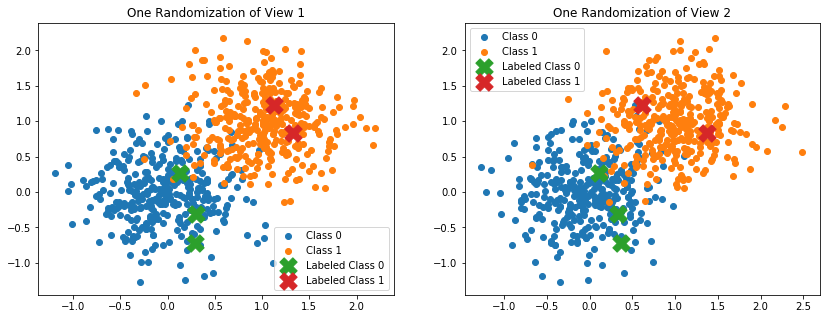

In [58]:
randomizations = 20
N_per_class = 500
view2_penalty = 'l1'

N_iters = np.arange(1, 202, 15)
acc_ct = [[] for _ in N_iters]
acc_view1 = []
acc_view2 = []
acc_combined = []


for count, iters in enumerate(N_iters):
    
    for seed in range(randomizations):
    
        ######################### Create Data ###########################  
        View1_train, View2_train, labels_train, labels_train_full, View1_test, View2_test, labels_test = create_data(seed, 1, .2, .2, N_per_class)

        # randomly remove some labels
        np.random.seed(11)
        remove_idx = np.random.rand(len(labels_train),) < .99
        labels_train[remove_idx] = np.nan
        not_removed = np.where(remove_idx==False)[0]
        
        # make sure both classes have at least 1 labeled example
        if len(set(labels_train[not_removed])) != 2:
            continue
            
        if seed == 0 and count == 0:
            scatterplot_classes(not_removed, labels_train, labels_train_full, View1_train, View2_train)

        ############## Single view semi-supervised learning ##############
        # Only do this calculation once, since not affected by number of iterations
        if count == 0:
            gnb0 = LogisticRegression()
            gnb1 = LogisticRegression(penalty=view2_penalty)

            # Train on only the examples with labels
            gnb0.fit(View1_train[not_removed,:].squeeze(), labels_train[not_removed])
            y_pred0 = gnb0.predict(View1_test)

            gnb1.fit(View2_train[not_removed,:].squeeze(), labels_train[not_removed])
            y_pred1 = gnb1.predict(View2_test)

            accuracy_view1 = (accuracy_score(labels_test, y_pred0))
            accuracy_view2 = (accuracy_score(labels_test, y_pred1))

            acc_view1.append(accuracy_view1)
            acc_view2.append(accuracy_view2)
            
            # Concatenate views in naive way and train model
            combined_labeled = np.hstack((View1_train[not_removed,:].squeeze(), View2_train[not_removed,:].squeeze()))
            combined_test = np.hstack((View1_test, View2_test))

            gnb2.fit(combined_labeled, labels_train[not_removed])
            y_pred2 = gnb2.predict(combined_test)

            accuracy_combined = (accuracy_score(labels_test, y_pred2))
            acc_combined.append(accuracy_combined)

        ##################### Multiview ########################################
        ctc = CTClassifier(LogisticRegression(), LogisticRegression(penalty=view2_penalty))
        ctc.fit([View1_train, View2_train], labels_train, num_iter=iters)
        y_pred_ct = ctc.predict([View1_test, View2_test])
        acc_ct[count].append((accuracy_score(labels_test, y_pred_ct)))

acc_view1 = np.mean(acc_view1)
acc_view2 = np.mean(acc_view2)
acc_combined = np.mean(acc_combined)
acc_ct = [sum(row) / float(len(row)) for row in acc_ct]


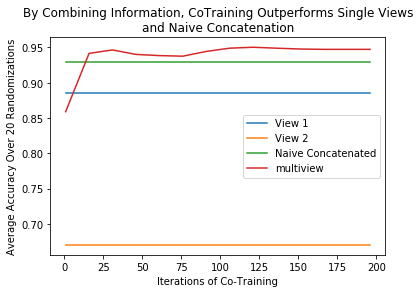

In [59]:
# make a figure from the data
plt.figure()
plt.plot(N_iters, acc_view1*np.ones(N_iters.shape))
plt.plot(N_iters, acc_view2*np.ones(N_iters.shape))
plt.plot(N_iters, acc_combined*np.ones(N_iters.shape))
plt.plot(N_iters, acc_ct)
plt.legend(('View 1', 'View 2', 'Naive Concatenated', 'multiview'))
plt.ylabel("Average Accuracy Over {} Randomizations".format(randomizations))
plt.xlabel('Iterations of Co-Training')
plt.title('By Combining Information, CoTraining Outperforms Single Views\nand Naive Concatenation')
plt.show()

### Performance when one view is totally redundant

Here, the 2 class distributions are the following
- Class 0 mean: [0, 0]
- Class 0 covariance: .2*eye(2)
- Class 1 mean: [1, 1]
- Class 1 covariance: .2*eye(2)

Views 1 and 2 hold the exact same samples

Labeled examples are chosen randomly from the training set

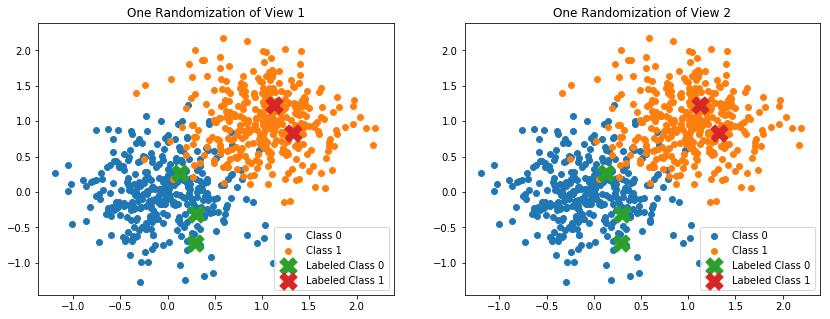

In [60]:
randomizations = 20
N_per_class = 500
view2_penalty = 'l1'

N_iters = np.arange(1, 202, 15)
acc_ct = [[] for _ in N_iters]
acc_view1 = []
acc_view2 = []
acc_combined = []


for count, iters in enumerate(N_iters):
    
    for seed in range(randomizations):
    
        ######################### Create Data ###########################  
        View1_train, View2_train, labels_train, labels_train_full, View1_test, View2_test, labels_test = create_data(seed, 1, .2, .2, N_per_class)

        View2_train = View1_train.copy()
        View2_test = View1_test.copy()
        
        # randomly remove some labels
        np.random.seed(11)
        remove_idx = np.random.rand(len(labels_train),) < .99
        labels_train[remove_idx] = np.nan
        not_removed = np.where(remove_idx==False)[0]
        
        # make sure both classes have at least 1 labeled example
        if len(set(labels_train[not_removed])) != 2:
            continue
            
        if seed == 0 and count == 0:
            scatterplot_classes(not_removed, labels_train, labels_train_full, View1_train, View2_train)

        ############## Single view semi-supervised learning ##############
        # Only do this calculation once, since not affected by number of iterations
        if count == 0:
            gnb0 = LogisticRegression()
            gnb1 = LogisticRegression(penalty=view2_penalty)

            # Train on only the examples with labels
            gnb0.fit(View1_train[not_removed,:].squeeze(), labels_train[not_removed])
            y_pred0 = gnb0.predict(View1_test)

            gnb1.fit(View2_train[not_removed,:].squeeze(), labels_train[not_removed])
            y_pred1 = gnb1.predict(View2_test)

            accuracy_view1 = (accuracy_score(labels_test, y_pred0))
            accuracy_view2 = (accuracy_score(labels_test, y_pred1))

            acc_view1.append(accuracy_view1)
            acc_view2.append(accuracy_view2)
            
            # Concatenate views in naive way and train model
            combined_labeled = np.hstack((View1_train[not_removed,:].squeeze(), View2_train[not_removed,:].squeeze()))
            combined_test = np.hstack((View1_test, View2_test))

            gnb2.fit(combined_labeled, labels_train[not_removed])
            y_pred2 = gnb2.predict(combined_test)

            accuracy_combined = (accuracy_score(labels_test, y_pred2))
            acc_combined.append(accuracy_combined)

        ##################### Multiview ########################################
        ctc = CTClassifier(LogisticRegression(), LogisticRegression(penalty=view2_penalty))
        ctc.fit([View1_train, View2_train], labels_train, num_iter=iters)
        y_pred_ct = ctc.predict([View1_test, View2_test])
        acc_ct[count].append((accuracy_score(labels_test, y_pred_ct)))

acc_view1 = np.mean(acc_view1)
acc_view2 = np.mean(acc_view2)
acc_combined = np.mean(acc_combined)
acc_ct = [sum(row) / float(len(row)) for row in acc_ct]


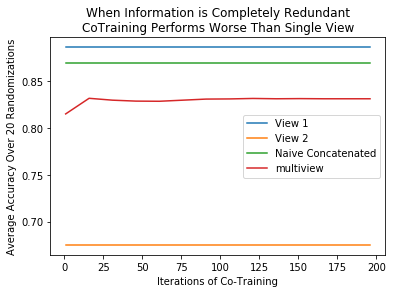

In [61]:
# make a figure from the data
plt.figure()
plt.plot(N_iters, acc_view1*np.ones(N_iters.shape))
plt.plot(N_iters, acc_view2*np.ones(N_iters.shape))
plt.plot(N_iters, acc_combined*np.ones(N_iters.shape))
plt.plot(N_iters, acc_ct)
plt.legend(('View 1', 'View 2', 'Naive Concatenated', 'multiview'))
plt.ylabel("Average Accuracy Over {} Randomizations".format(randomizations))
plt.xlabel('Iterations of Co-Training')
plt.title('When Information is Completely Redundant\nCoTraining Performs Worse Than Single View')
plt.show()

### Performance when labeled data is excellent

Here, the 2 class distributions are the following
- Class 0 mean: [0, 0]
- Class 0 covariance: .2*eye(2)
- Class 1 mean: [1, 1]
- Class 1 covariance: .2*eye(2)

Labeled examples are chosen to be very close to the mean of their respective class
- Normally distributed around their class mean with standard deviation 0.05 in both dimensions

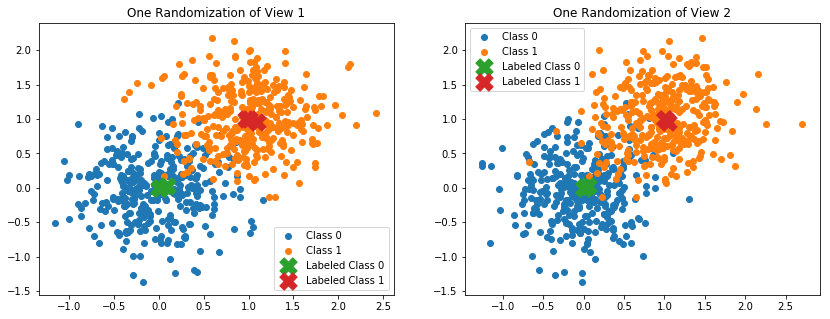

In [62]:
randomizations = 20
N_per_class = 500
num_perfect = 3
perfect_scale = 0.05

N_iters = np.arange(1, 202, 15)
acc_ct = [[] for _ in N_iters]
acc_view1 = []
acc_view2 = []
acc_combined = []


for count, iters in enumerate(N_iters):
    
    for seed in range(randomizations):
    
        ######################### Create Data ###########################
        np.random.seed(seed)

        view1_mu0 = np.zeros(2,)
        view1_mu1 = np.ones(2,)
        view1_cov = .2*np.eye(2)

        view2_mu0 = np.zeros(2,)
        view2_mu1 = np.ones(2,)
        view2_cov = .2*np.eye(2)
        
        # generage perfect examples
        perfect_class0_v1 = view1_mu0 + np.random.normal(loc=0, scale=perfect_scale, size=view1_mu0.shape)
        perfect_class0_v2 = view1_mu0 + np.random.normal(loc=0, scale=perfect_scale, size=view1_mu0.shape)
        perfect_class1_v1 = view1_mu1 + np.random.normal(loc=0, scale=perfect_scale, size=view1_mu1.shape)
        perfect_class1_v2 = view1_mu1 + np.random.normal(loc=0, scale=perfect_scale, size=view1_mu1.shape)
        for p in range(1, num_perfect):
            perfect_class0_v1 = np.vstack((perfect_class0_v1, view1_mu0 + np.random.normal(loc=0, scale=0.01, size=view1_mu0.shape)))
            perfect_class0_v2 = np.vstack((perfect_class0_v2, view1_mu0 + np.random.normal(loc=0, scale=0.01, size=view1_mu0.shape)))
            perfect_class1_v1 = np.vstack((perfect_class1_v1, view1_mu1 + np.random.normal(loc=0, scale=0.01, size=view1_mu1.shape)))
            perfect_class1_v2 = np.vstack((perfect_class1_v2, view1_mu1 + np.random.normal(loc=0, scale=0.01, size=view1_mu1.shape)))
        perfect_labels = np.zeros(num_perfect,)
        perfect_labels = np.concatenate((perfect_labels, np.ones(num_perfect,)))
        

        view1_class0 = np.random.multivariate_normal(view1_mu0, view1_cov, size=N_per_class)
        view1_class1 = np.random.multivariate_normal(view1_mu1, view1_cov, size=N_per_class)

        view2_class0 = np.random.multivariate_normal(view2_mu0, view2_cov, size=N_per_class)
        view2_class1 = np.random.multivariate_normal(view2_mu1, view2_cov, size=N_per_class)

        View1 = np.concatenate((view1_class0, view1_class1))
        View2 = np.concatenate((view2_class0, view2_class1))
        Labels = np.concatenate((np.zeros(N_per_class,), np.ones(N_per_class,)))
    
        
        # Split both views into testing and training
        View1_train, View1_test, labels_train_full, labels_test_full = train_test_split(View1, Labels, test_size=0.3, random_state=42)
        View2_train, View2_test, labels_train_full, labels_test_full = train_test_split(View2, Labels, test_size=0.3, random_state=42)

        labels_train = labels_train_full.copy()
        labels_test = labels_test_full.copy()

        
        # Add the perfect examples
        View1_train = np.vstack((View1_train, perfect_class0_v1, perfect_class1_v1))
        View2_train = np.vstack((View2_train, perfect_class0_v2, perfect_class1_v2))
        labels_train = np.concatenate((labels_train, perfect_labels)) 

        # randomly remove all but perfect labeled samples
        remove_idx = [True for i in range(len(labels_train)-2*num_perfect)]
        for i in range(2*num_perfect):
            remove_idx.append(False)                                       
        
        #remove_idx = [False if i < (len(labels_train)-2*num_perfect) else True for i in range(len(labels_train))]
        labels_train[remove_idx] = np.nan
        not_removed = np.where(remove_idx==False)[0]
        not_removed = np.arange(len(labels_train)-2*num_perfect, len(labels_train))
        
        # make sure both classes have at least 1 labeled example
        if len(set(labels_train[not_removed])) != 2:
            continue

        if seed == 0 and count == 0:
            scatterplot_classes(not_removed, labels_train, labels_train_full, View1_train, View2_train)
        
        ############## Single view semi-supervised learning ##############
        # Only once, since not affected by "num iters"
        if count == 0:
            gnb0 = LogisticRegression()
            gnb1 = LogisticRegression(penalty=view2_penalty)

            # Train on only the examples with labels
            gnb0.fit(View1_train[not_removed,:].squeeze(), labels_train[not_removed])
            y_pred0 = gnb0.predict(View1_test)

            gnb1.fit(View2_train[not_removed,:].squeeze(), labels_train[not_removed])
            y_pred1 = gnb1.predict(View2_test)

            accuracy_view1 = (accuracy_score(labels_test, y_pred0))
            accuracy_view2 = (accuracy_score(labels_test, y_pred1))

            acc_view1.append(accuracy_view1)
            acc_view2.append(accuracy_view2)

            # Concatenate views in naive way and train model
            combined_labeled = np.hstack((View1_train[not_removed,:].squeeze(), View2_train[not_removed,:].squeeze()))
            combined_test = np.hstack((View1_test, View2_test))

            gnb2.fit(combined_labeled, labels_train[not_removed])
            y_pred2 = gnb2.predict(combined_test)

            accuracy_combined = (accuracy_score(labels_test, y_pred2))
            acc_combined.append(accuracy_combined)


        ##################### Multiview ########################################
        ctc = CTClassifier(LogisticRegression(), LogisticRegression(view2_penalty))
        ctc.fit([View1_train, View2_train], labels_train, num_iter=iters)
        y_pred_ct = ctc.predict([View1_test, View2_test])
        acc_ct[count].append((accuracy_score(labels_test, y_pred_ct)))
        
acc_view1 = np.mean(acc_view1)
acc_view2 = np.mean(acc_view2)
acc_combined = np.mean(acc_combined)
acc_ct = [sum(row) / float(len(row)) for row in acc_ct]

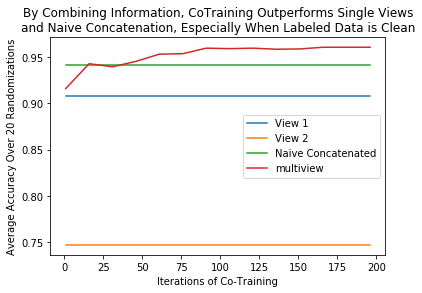

In [63]:
# make a figure from the data
plt.figure()
plt.plot(N_iters, acc_view1*np.ones(N_iters.shape))
plt.plot(N_iters, acc_view2*np.ones(N_iters.shape))
plt.plot(N_iters, acc_combined*np.ones(N_iters.shape))
plt.plot(N_iters, acc_ct)
plt.legend(('View 1', 'View 2', 'Naive Concatenated', 'multiview'))
plt.ylabel("Average Accuracy Over {} Randomizations".format(randomizations))
plt.xlabel('Iterations of Co-Training')
plt.title('By Combining Information, CoTraining Outperforms Single Views\nand Naive Concatenation, Especially When Labeled Data is Clean')
plt.show()

### Performance when labeled data is not as separable

Here, the 2 class distributions are the following
- Class 0 mean: [0, 0]
- Class 0 covariance: .2*eye(2)
- Class 1 mean: [1, 1]
- Class 1 covariance: .2*eye(2)

Labeled examples are chosen to be far from their respective means according to a uniform distribution in 2 dimensions between .2 and .75 away from the x1 or x2 coordinate of the mean

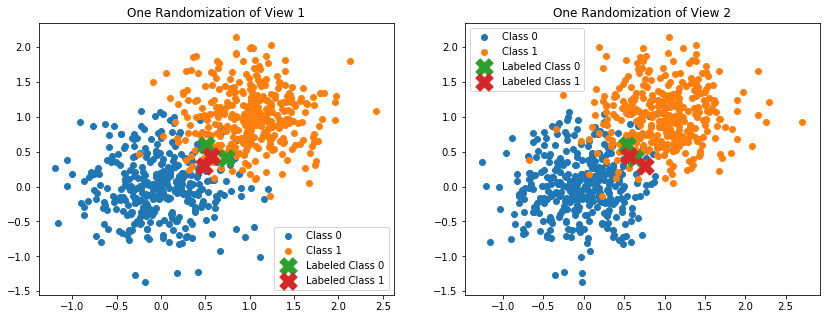

In [64]:
randomizations = 20
N_per_class = 500
num_perfect = 2
uniform_min = 0.2
uniform_max = 0.75

N_iters = np.arange(1, 202, 15)
acc_ct = [[] for _ in N_iters]
acc_view1 = []
acc_view2 = []
acc_combined = []


for count, iters in enumerate(N_iters):
    
    for seed in range(randomizations):
    
        ######################### Create Data ###########################
        np.random.seed(seed)

        view1_mu0 = np.zeros(2,)
        view1_mu1 = np.ones(2,)
        view1_cov = .2*np.eye(2)

        view2_mu0 = np.zeros(2,)
        view2_mu1 = np.ones(2,)
        view2_cov = .2*np.eye(2)
        
        # generage bad examples
        perfect_class0_v1 = view1_mu0 + np.random.uniform(uniform_min, uniform_max, size=view1_mu0.shape)
        perfect_class0_v2 = view1_mu0 + np.random.uniform(uniform_min, uniform_max, size=view1_mu0.shape)
        perfect_class1_v1 = view1_mu1 - np.random.uniform(uniform_min, uniform_max, size=view1_mu0.shape)
        perfect_class1_v2 = view1_mu1 - np.random.uniform(uniform_min, uniform_max, size=view1_mu0.shape)
        for p in range(1, num_perfect):
            perfect_class0_v1 = np.vstack((perfect_class0_v1, view1_mu0 + np.random.uniform(uniform_min, uniform_max, size=view1_mu0.shape)))
            perfect_class0_v2 = np.vstack((perfect_class0_v2, view1_mu0 + np.random.uniform(uniform_min, uniform_max, size=view1_mu0.shape)))
            perfect_class1_v1 = np.vstack((perfect_class1_v1, view1_mu1 - np.random.uniform(uniform_min, uniform_max, size=view1_mu0.shape)))
            perfect_class1_v2 = np.vstack((perfect_class1_v2, view1_mu1 - np.random.uniform(uniform_min, uniform_max, size=view1_mu0.shape)))
        perfect_labels = np.zeros(num_perfect,)
        perfect_labels = np.concatenate((perfect_labels, np.ones(num_perfect,)))

        view1_class0 = np.random.multivariate_normal(view1_mu0, view1_cov, size=N_per_class)
        view1_class1 = np.random.multivariate_normal(view1_mu1, view1_cov, size=N_per_class)

        view2_class0 = np.random.multivariate_normal(view2_mu0, view2_cov, size=N_per_class)
        view2_class1 = np.random.multivariate_normal(view2_mu1, view2_cov, size=N_per_class)

        View1 = np.concatenate((view1_class0, view1_class1))
        View2 = np.concatenate((view2_class0, view2_class1))
        Labels = np.concatenate((np.zeros(N_per_class,), np.ones(N_per_class,)))
    
        
        # Split both views into testing and training
        View1_train, View1_test, labels_train_full, labels_test_full = train_test_split(View1, Labels, test_size=0.3, random_state=42)
        View2_train, View2_test, labels_train_full, labels_test_full = train_test_split(View2, Labels, test_size=0.3, random_state=42)

        labels_train = labels_train_full.copy()
        labels_test = labels_test_full.copy()

        
        # Add the perfect examples
        View1_train = np.vstack((View1_train, perfect_class0_v1, perfect_class1_v1))
        View2_train = np.vstack((View2_train, perfect_class0_v2, perfect_class1_v2))
        labels_train = np.concatenate((labels_train, perfect_labels)) 

        # randomly remove all but perfect labeled samples
        remove_idx = [True for i in range(len(labels_train)-2*num_perfect)]
        for i in range(2*num_perfect):
            remove_idx.append(False)
                                                 
        
        labels_train[remove_idx] = np.nan
        not_removed = np.where(remove_idx==False)[0]
        not_removed = np.arange(len(labels_train)-2*num_perfect, len(labels_train))
        
        # make sure both classes have at least 1 labeled example
        if len(set(labels_train[not_removed])) != 2:
            continue

        if seed == 0 and count == 0:
            
            scatterplot_classes(not_removed, labels_train, labels_train_full, View1_train, View2_train)
        
        ############## Single view semi-supervised learning ##############
        # Only once, since not affected by "num iters"
        if count == 0:
            gnb0 = LogisticRegression()
            gnb1 = LogisticRegression(penalty=view2_penalty)

            # Train on only the examples with labels
            gnb0.fit(View1_train[not_removed,:].squeeze(), labels_train[not_removed])
            y_pred0 = gnb0.predict(View1_test)

            gnb1.fit(View2_train[not_removed,:].squeeze(), labels_train[not_removed])
            y_pred1 = gnb1.predict(View2_test)

            accuracy_view1 = (accuracy_score(labels_test, y_pred0))
            accuracy_view2 = (accuracy_score(labels_test, y_pred1))

            acc_view1.append(accuracy_view1)
            acc_view2.append(accuracy_view2)

            # Concatenate views in naive way and train model
            combined_labeled = np.hstack((View1_train[not_removed,:].squeeze(), View2_train[not_removed,:].squeeze()))
            combined_test = np.hstack((View1_test, View2_test))

            gnb2.fit(combined_labeled, labels_train[not_removed])
            y_pred2 = gnb2.predict(combined_test)

            accuracy_combined = (accuracy_score(labels_test, y_pred2))
            acc_combined.append(accuracy_combined)


        ##################### Multiview ########################################
        ctc = CTClassifier(LogisticRegression(), LogisticRegression(view2_penalty))
        ctc.fit([View1_train, View2_train], labels_train, num_iter=iters)
        y_pred_ct = ctc.predict([View1_test, View2_test])
        acc_ct[count].append((accuracy_score(labels_test, y_pred_ct)))

        
acc_view1 = np.mean(acc_view1)
acc_view2 = np.mean(acc_view2)
acc_combined = np.mean(acc_combined)
acc_ct = [sum(row) / float(len(row)) for row in acc_ct]

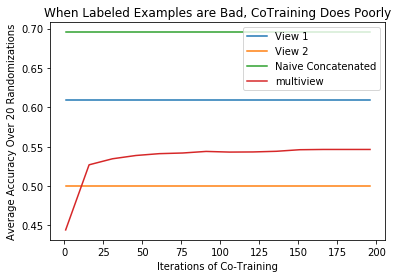

In [65]:
# make a figure from the data
plt.figure()
plt.plot(N_iters, acc_view1*np.ones(N_iters.shape))
plt.plot(N_iters, acc_view2*np.ones(N_iters.shape))
plt.plot(N_iters, acc_combined*np.ones(N_iters.shape))
plt.plot(N_iters, acc_ct)
plt.legend(('View 1', 'View 2', 'Naive Concatenated', 'multiview'))
plt.ylabel("Average Accuracy Over {} Randomizations".format(randomizations))
plt.xlabel('Iterations of Co-Training')
plt.title('When Labeled Examples are Bad, CoTraining Does Poorly')
plt.show()

### Performance when data is overlapping

Here, the 2 class distributions are the following
- Class 0 mean: [0, 0]
- Class 0 covariance: .2*eye(2)
- Class 1 mean: [0, 0]
- Class 1 covariance: .2*eye(2)

Labeled examples are chosen randomly from the training set

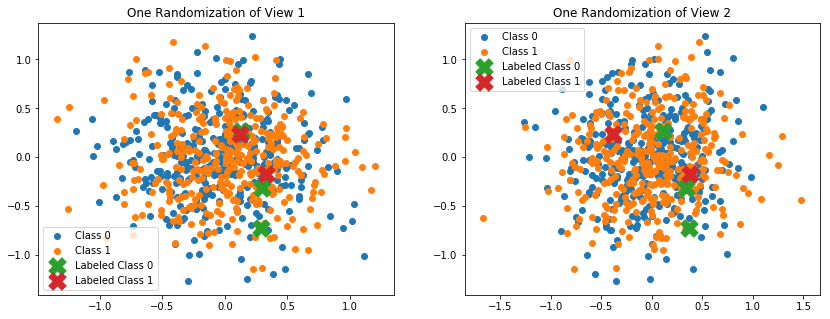

In [68]:
randomizations = 20
N_per_class = 500
view2_penalty = 'l1'
class2_mean_center = 0 # 1 would make this identical to first test

N_iters = np.arange(1, 202, 15)
acc_ct = [[] for _ in N_iters]
acc_view1 = []
acc_view2 = []
acc_combined = []


for count, iters in enumerate(N_iters):
    
    for seed in range(randomizations):
    
        ######################### Create Data ###########################  
        View1_train, View2_train, labels_train, labels_train_full, View1_test, View2_test, labels_test = create_data(seed, 0, .2, .2, N_per_class)

        # randomly remove some labels
        np.random.seed(11)
        remove_idx = np.random.rand(len(labels_train),) < .99
        labels_train[remove_idx] = np.nan
        not_removed = np.where(remove_idx==False)[0]
        
        # make sure both classes have at least 1 labeled example
        if len(set(labels_train[not_removed])) != 2:
            continue
            
        if seed == 0 and count == 0:
            
            scatterplot_classes(not_removed, labels_train, labels_train_full, View1_train, View2_train)
        
        ############## Single view semi-supervised learning ##############
        # Only once, since not affected by "num iters"
        if count == 0:
            gnb0 = LogisticRegression()
            gnb1 = LogisticRegression(penalty=view2_penalty)

            # Train on only the examples with labels
            gnb0.fit(View1_train[not_removed,:].squeeze(), labels_train[not_removed])
            y_pred0 = gnb0.predict(View1_test)

            gnb1.fit(View2_train[not_removed,:].squeeze(), labels_train[not_removed])
            y_pred1 = gnb1.predict(View2_test)

            accuracy_view1 = (accuracy_score(labels_test, y_pred0))
            accuracy_view2 = (accuracy_score(labels_test, y_pred1))

            acc_view1.append(accuracy_view1)
            acc_view2.append(accuracy_view2)

            # Concatenate views in naive way and train model
            combined_labeled = np.hstack((View1_train[not_removed,:].squeeze(), View2_train[not_removed,:].squeeze()))
            combined_test = np.hstack((View1_test, View2_test))

            gnb2.fit(combined_labeled, labels_train[not_removed])
            y_pred2 = gnb2.predict(combined_test)

            accuracy_combined = (accuracy_score(labels_test, y_pred2))
            acc_combined.append(accuracy_combined)

        ##################### Multiview ########################################
        ctc = CTClassifier(LogisticRegression(), LogisticRegression(penalty=view2_penalty))
        ctc.fit([View1_train, View2_train], labels_train, num_iter=iters)
        y_pred_ct = ctc.predict([View1_test, View2_test])
        acc_ct[count].append((accuracy_score(labels_test, y_pred_ct)))

acc_view1 = np.mean(acc_view1)
acc_view2 = np.mean(acc_view2)
acc_combined = np.mean(acc_combined)
acc_ct = [sum(row) / float(len(row)) for row in acc_ct]



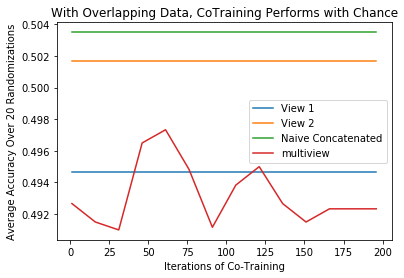

In [69]:
# make a figure from the data
plt.figure()
plt.plot(N_iters, acc_view1*np.ones(N_iters.shape))
plt.plot(N_iters, acc_view2*np.ones(N_iters.shape))
plt.plot(N_iters, acc_combined*np.ones(N_iters.shape))
plt.plot(N_iters, acc_ct)
plt.legend(('View 1', 'View 2', 'Naive Concatenated', 'multiview'))
plt.ylabel("Average Accuracy Over {} Randomizations".format(randomizations))
plt.xlabel('Iterations of Co-Training')
plt.title('With Overlapping Data, CoTraining Performs with Chance')
plt.show()

### Performance as labeled data proportion (essentially sample size) is varied

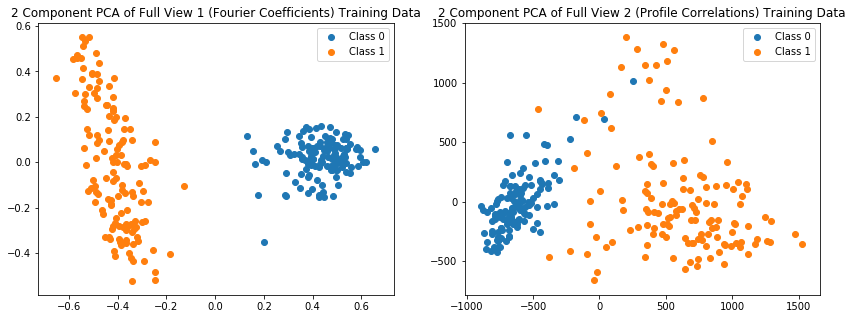

In [70]:
data, labels = load_UCImultifeature(select_labeled=[0,1])

# Use only the first 2 views as an example
View0, View1 = data[0], data[1]

# Split both views into testing and training
View0_train, View0_test, labels_train_full, labels_test_full = train_test_split(View0, labels, test_size=0.33, random_state=42)
View1_train, View1_test, labels_train_full, labels_test_full = train_test_split(View1, labels, test_size=0.33, random_state=42)

# Do PCA to visualize data
pca = PCA(n_components = 2)
View0_pca = pca.fit_transform(View0_train)
View1_pca = pca.fit_transform(View1_train)

View0_pca_class0 = View0_pca[np.where(labels_train_full==0)[0],:]
View0_pca_class1 = View0_pca[np.where(labels_train_full==1)[0],:]
View1_pca_class0 = View1_pca[np.where(labels_train_full==0)[0],:]
View1_pca_class1 = View1_pca[np.where(labels_train_full==1)[0],:]


# plot the views
plt.figure()
fig, ax = plt.subplots(1,2, figsize=(14,5))

ax[0].scatter(View0_pca_class0[:,0], View0_pca_class0[:,1])
ax[0].scatter(View0_pca_class1[:,0], View0_pca_class1[:,1])
ax[0].set_title('2 Component PCA of Full View 1 (Fourier Coefficients) Training Data')
ax[0].legend(('Class 0', 'Class 1'))

ax[1].scatter(View1_pca_class0[:,0], View1_pca_class0[:,1])
ax[1].scatter(View1_pca_class1[:,0], View1_pca_class1[:,1])
ax[1].set_title('2 Component PCA of Full View 2 (Profile Correlations) Training Data')
ax[1].legend(('Class 0', 'Class 1'))

plt.show()


In [71]:
N_labeled_full = []
acc_ct_full = []
acc_v0_full = []
acc_v1_full = []

acc_ct_flip_full = []
acc_ct_flip50_full = []

Reverse_Labels = True

iters = 500

for i, num in zip(np.linspace(0.03, .30, 20), (np.linspace(4, 30, 20)).astype(int)):
    
    N_labeled = []
    acc_ct = []
    acc_v0 = []
    acc_v1 = []
    
    acc_ct_flip = []
    acc_ct_flip50 = []
    
    View0_train, View0_test, labels_train_full, labels_test_full = train_test_split(View0, labels, test_size=0.33, random_state=42)
    View1_train, View1_test, labels_train_full, labels_test_full = train_test_split(View1, labels, test_size=0.33, random_state=42)
    
    for seed in range(iters):
    
        labels_train = labels_train_full.copy()
        labels_test = labels_test_full.copy()
        
        # Randomly remove all but 4 of the labels
        np.random.seed(2*seed) #6
        remove_idx = np.random.rand(len(labels_train),) < 1-i
        labels_train[remove_idx] = np.nan
        not_removed = np.where(remove_idx==False)[0]
        not_removed = not_removed[:num]
        N_labeled.append(len(labels_train[not_removed])/len(labels_train))
        if len(set(labels_train[not_removed])) != 2:
            continue
        
        if Reverse_Labels:
            labels_one_idx = np.argwhere(labels_train == 1)
            labels_zero_idx = np.argwhere(labels_train == 0)
            labels_trainFlipped = labels_train.copy()
            labels_trainFlipped50 = labels_trainFlipped.copy()
            labels_trainFlipped50[labels_one_idx[:len(labels_one_idx)//2]] = 0
            labels_trainFlipped50[labels_zero_idx[:len(labels_zero_idx)//2]] = 1
            labels_trainFlipped[labels_one_idx[:len(labels_one_idx)]] = 0
            labels_trainFlipped[labels_zero_idx[:len(labels_zero_idx)]] = 1
            
        ############## Single view semi-supervised learning ##############
        #-----------------------------------------------------------------
        gnb0 = GaussianNB()
        gnb1 = GaussianNB()

        # Train on only the examples with labels
        gnb0.fit(View0_train[not_removed,:].squeeze(), labels_train[not_removed])

        y_pred0 = gnb0.predict(View0_test)
        gnb1.fit(View1_train[not_removed,:].squeeze(), labels_train[not_removed])
        y_pred1 = gnb1.predict(View1_test)

        acc_v0.append(accuracy_score(labels_test, y_pred0))
        acc_v1.append(accuracy_score(labels_test, y_pred1))

        ######### Multi-view co-training semi-supervised learning #########
        #------------------------------------------------------------------
        # Train a CTClassifier on all the labeled and unlabeled training data
        ctc = CTClassifier()
        ctc.fit([View0_train, View1_train], labels_train)
        y_pred_ct = ctc.predict([View0_test, View1_test])
        acc_ct.append(accuracy_score(labels_test, y_pred_ct))
        
        ###################################################################
        # Flipped labels
        ######### Multi-view co-training semi-supervised learning #########
        #------------------------------------------------------------------
        # Train a CTClassifier on all the labeled and unlabeled training data
        if Reverse_Labels:
            ctc_flip = CTClassifier()
            ctc_flip.fit([View0_train, View1_train], labels_trainFlipped)
            y_pred_ct_flip = ctc_flip.predict([View0_test, View1_test])
            acc_ct_flip.append(accuracy_score(labels_test, y_pred_ct_flip))
            
            ctc_flip50 = CTClassifier()
            ctc_flip50.fit([View0_train, View1_train], labels_trainFlipped50)
            y_pred_ct_flip50 = ctc_flip50.predict([View0_test, View1_test])
            acc_ct_flip50.append(accuracy_score(labels_test, y_pred_ct_flip50))       
        
        
    acc_ct_full.append(np.mean(acc_ct))
    acc_v0_full.append(np.mean(acc_v0))
    acc_v1_full.append(np.mean(acc_v1))
    N_labeled_full.append(np.mean(N_labeled))
    if Reverse_Labels:
        acc_ct_flip_full.append(np.mean(acc_ct_flip))
        acc_ct_flip50_full.append(np.mean(acc_ct_flip50))

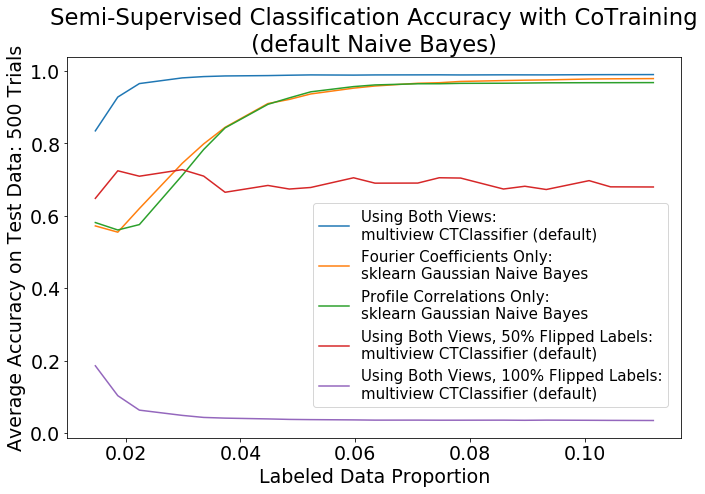

In [72]:
matplotlib.rcParams.update({'font.size': 19})
if Reverse_Labels:
    plt.figure(figsize=(11,7))
    plt.plot(N_labeled_full, acc_ct_full)
    plt.plot(N_labeled_full, acc_v0_full)
    plt.plot(N_labeled_full, acc_v1_full)
    plt.plot(N_labeled_full, acc_ct_flip50_full)
    plt.plot(N_labeled_full, acc_ct_flip_full)
    
    plt.legend(("Using Both Views:\nmultiview CTClassifier (default)", "Fourier Coefficients Only:\nsklearn Gaussian Naive Bayes", "Profile Correlations Only:\nsklearn Gaussian Naive Bayes", "Using Both Views, 50% Flipped Labels:\nmultiview CTClassifier (default)", "Using Both Views, 100% Flipped Labels:\nmultiview CTClassifier (default)"), loc=(.4, .08), fontsize=15)
    plt.title("Semi-Supervised Classification Accuracy with CoTraining\n(default Naive Bayes)")
    plt.xlabel("Labeled Data Proportion")
    plt.ylabel("Average Accuracy on Test Data: {} Trials".format(iters))
    #plt.savefig('AvgAccuracy_CTClassifier_withFlipped.png', bbox_inches='tight')
    plt.show()
    
else:
    plt.figure()
    plt.plot(N_labeled_full, acc_ct_full)
    plt.plot(N_labeled_full, acc_v0_full)
    plt.plot(N_labeled_full, acc_v1_full)
    plt.legend(("Using Both Views:\nmultiview CTClassifier (default)", "Fourier Coefficients Only:\nsklearn Gaussian Naive Bayes", "Profile Correlations Only:\nsklearn Gaussian Naive Bayes"))
    plt.title("Semi-Supervised Classification Accuracy with CoTraining\n(default Naive Bayes)")
    plt.xlabel("Labeled Data Proportion")
    plt.ylabel("Average Accuracy on Test Data: {} Trials".format(iters))
    #plt.savefig('AvgAccuracy_CTClassifier.png', bbox_inches='tight')
    plt.show()
